# Importing required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Conv2D, Flatten,Input,Dropout,MaxPooling2D, MaxPool2D
from keras.layers import  Activation, BatchNormalization 
from tensorflow.keras import datasets, layers, models
from tensorflow.math import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB4, Xception, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import RocCurveDisplay,accuracy_score, f1_score, recall_score,\
                            precision_score, make_scorer,\
                            classification_report,confusion_matrix,\
                            ConfusionMatrixDisplay, average_precision_score,\
                            roc_curve, roc_auc_score, auc
import random
import os
import cv2
import warnings
warnings.filterwarnings('ignore')

In [2]:
train_dir = '../input/dog-breed-identification/train'
test_dir = '../input/dog-breed-identification/test'

In [3]:
train_size = len(os.listdir('../input/dog-breed-identification/train'))
test_size = len(os.listdir('../input/dog-breed-identification/test'))

train_size,test_size

(10222, 10357)

In [4]:
df = pd.read_csv('../input/dog-breed-identification/labels.csv')
df.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

Sınıf sayısı:  120


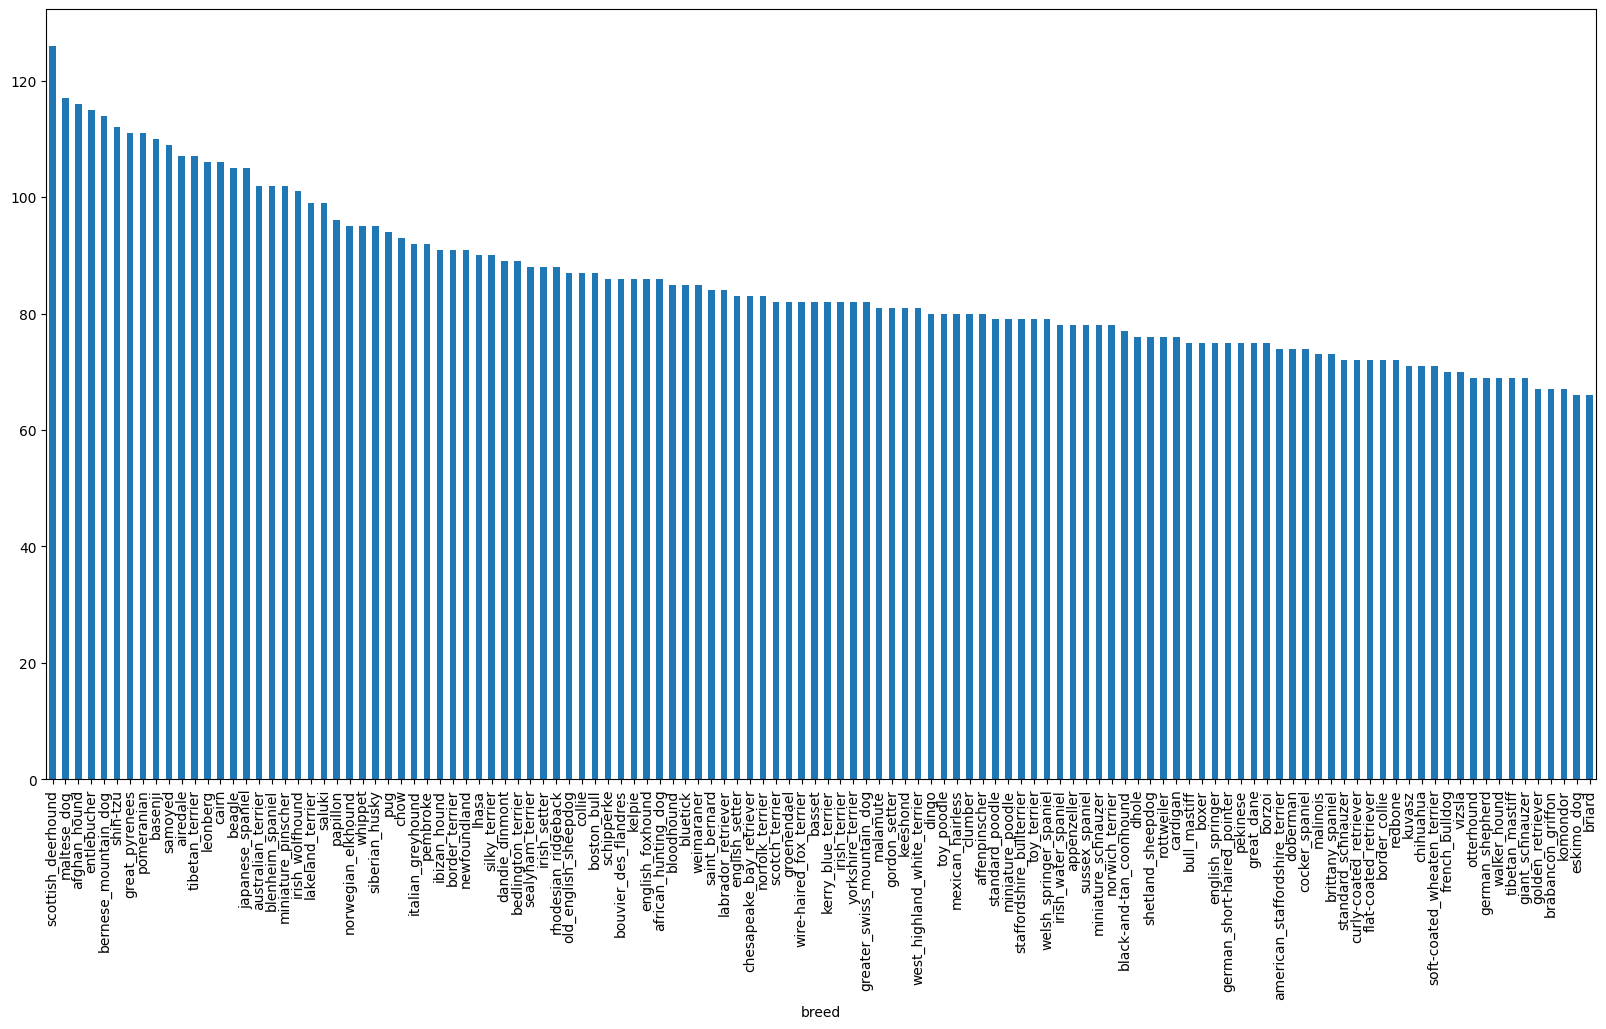

In [5]:
#Extracting different classes
dog_breeds = sorted(df['breed'].unique())
n_classes = len(dog_breeds)
print("Sınıf sayısı: ",n_classes)
dog_breeds

df["breed"].value_counts().plot.bar(figsize=(20, 10));



In [6]:
df.isna().sum()

id       0
breed    0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


In [8]:
df.shape


(10222, 2)

In [9]:
df.head()


id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

# Image Prep

In [10]:
train_path = "../input/dog-breed-identification/train/"
filenames = [train_path + fname + ".jpg" for fname in df["id"]]

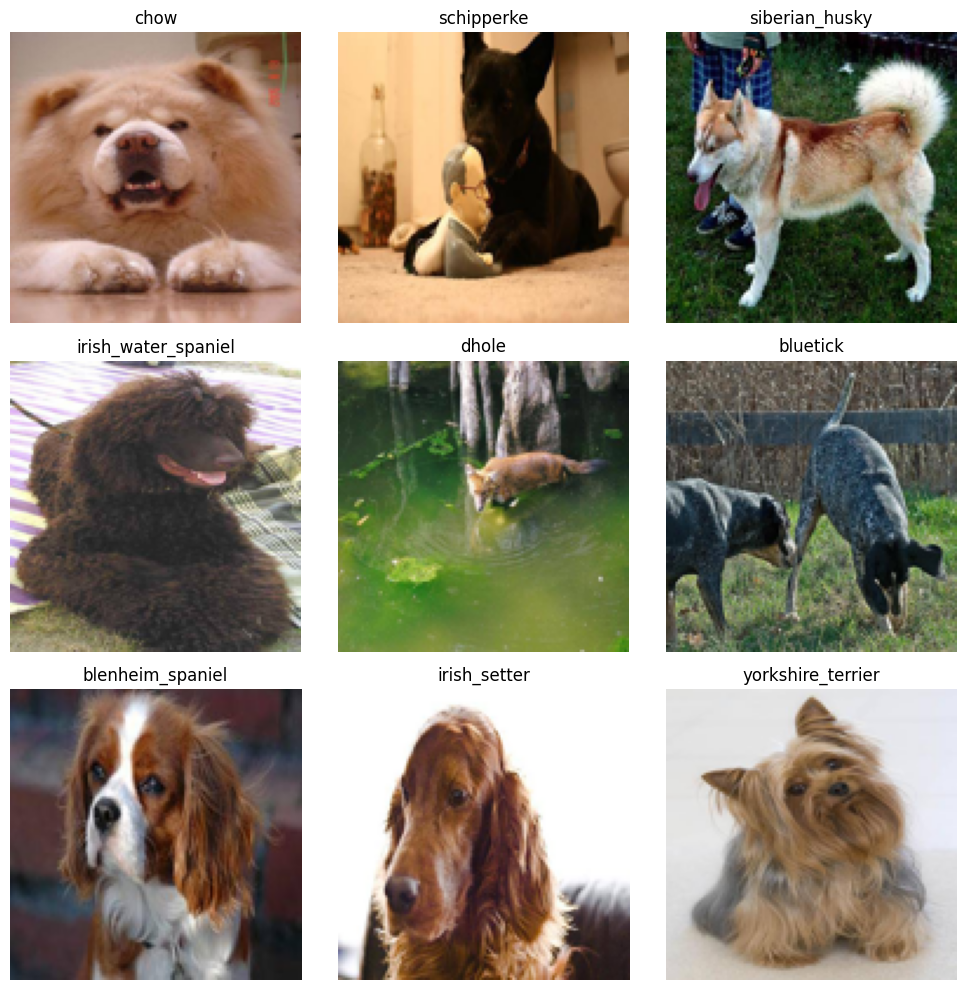

In [11]:
from PIL import Image
import random
random_images = random.sample(filenames, 9)

fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    
    img_path = random_images[i]
    img = Image.open(img_path)
    label = df[df["id"] == os.path.splitext(os.path.basename(img_path))[0]]["breed"].values[0]
    
    img = img.resize((124,124))
    ax.imshow(img)
    ax.set_title(label)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [12]:
labels = df["breed"].to_numpy()
unique_breeds = np.unique(labels)
print(len(unique_breeds))
boolean_labels = [label == np.array(unique_breeds) for label in labels]
X = filenames
y = boolean_labels

print(f"Number of training images: {len(X)}")
print(f"Number of labels: {len(y)}")

120
Number of training images: 10222
Number of labels: 10222


In [13]:
X = filenames
y = [np.where(label)[0][0] for label in boolean_labels]

# Create a DataFrame
train_df = pd.DataFrame({'image': X, 'label': y})

# Display the DataFrame
train_df.sample(10)

image  label
1172   ../input/dog-breed-identification/train/1d499d...     35
8142   ../input/dog-breed-identification/train/cb981a...     94
4820   ../input/dog-breed-identification/train/78e7aa...      1
7213   ../input/dog-breed-identification/train/b4b94f...     84
2807   ../input/dog-breed-identification/train/4505c9...     75
9230   ../input/dog-breed-identification/train/e7f491...     26
492    ../input/dog-breed-identification/train/0be68a...     17
10112  ../input/dog-breed-identification/train/fd22da...     14
5926   ../input/dog-breed-identification/train/95ba20...     41
6775   ../input/dog-breed-identification/train/aa4554...     42

# Data Augmentation

In [14]:
refactor_size = 128
resized_image_list = []
all_paths = []

# Loop through the DataFrame to load and process images
for i in range(len(train_df)):
    image_path = train_df.iloc[i]['image']
    label = train_df.iloc[i]['label']

    # Load and process the image
    img = tf.keras.utils.load_img(image_path, target_size=(refactor_size, refactor_size))
    img_vals = tf.image.convert_image_dtype(img, tf.float32) # 0 ile 1 arasinda normallestir.
    imgarr = tf.keras.utils.img_to_array(img_vals)

    # Append the processed image and label to the lists
    resized_image_list.append(imgarr)
    all_paths.append(image_path)

# Convert the lists to numpy arrays
resized_image_list = np.asarray(resized_image_list)

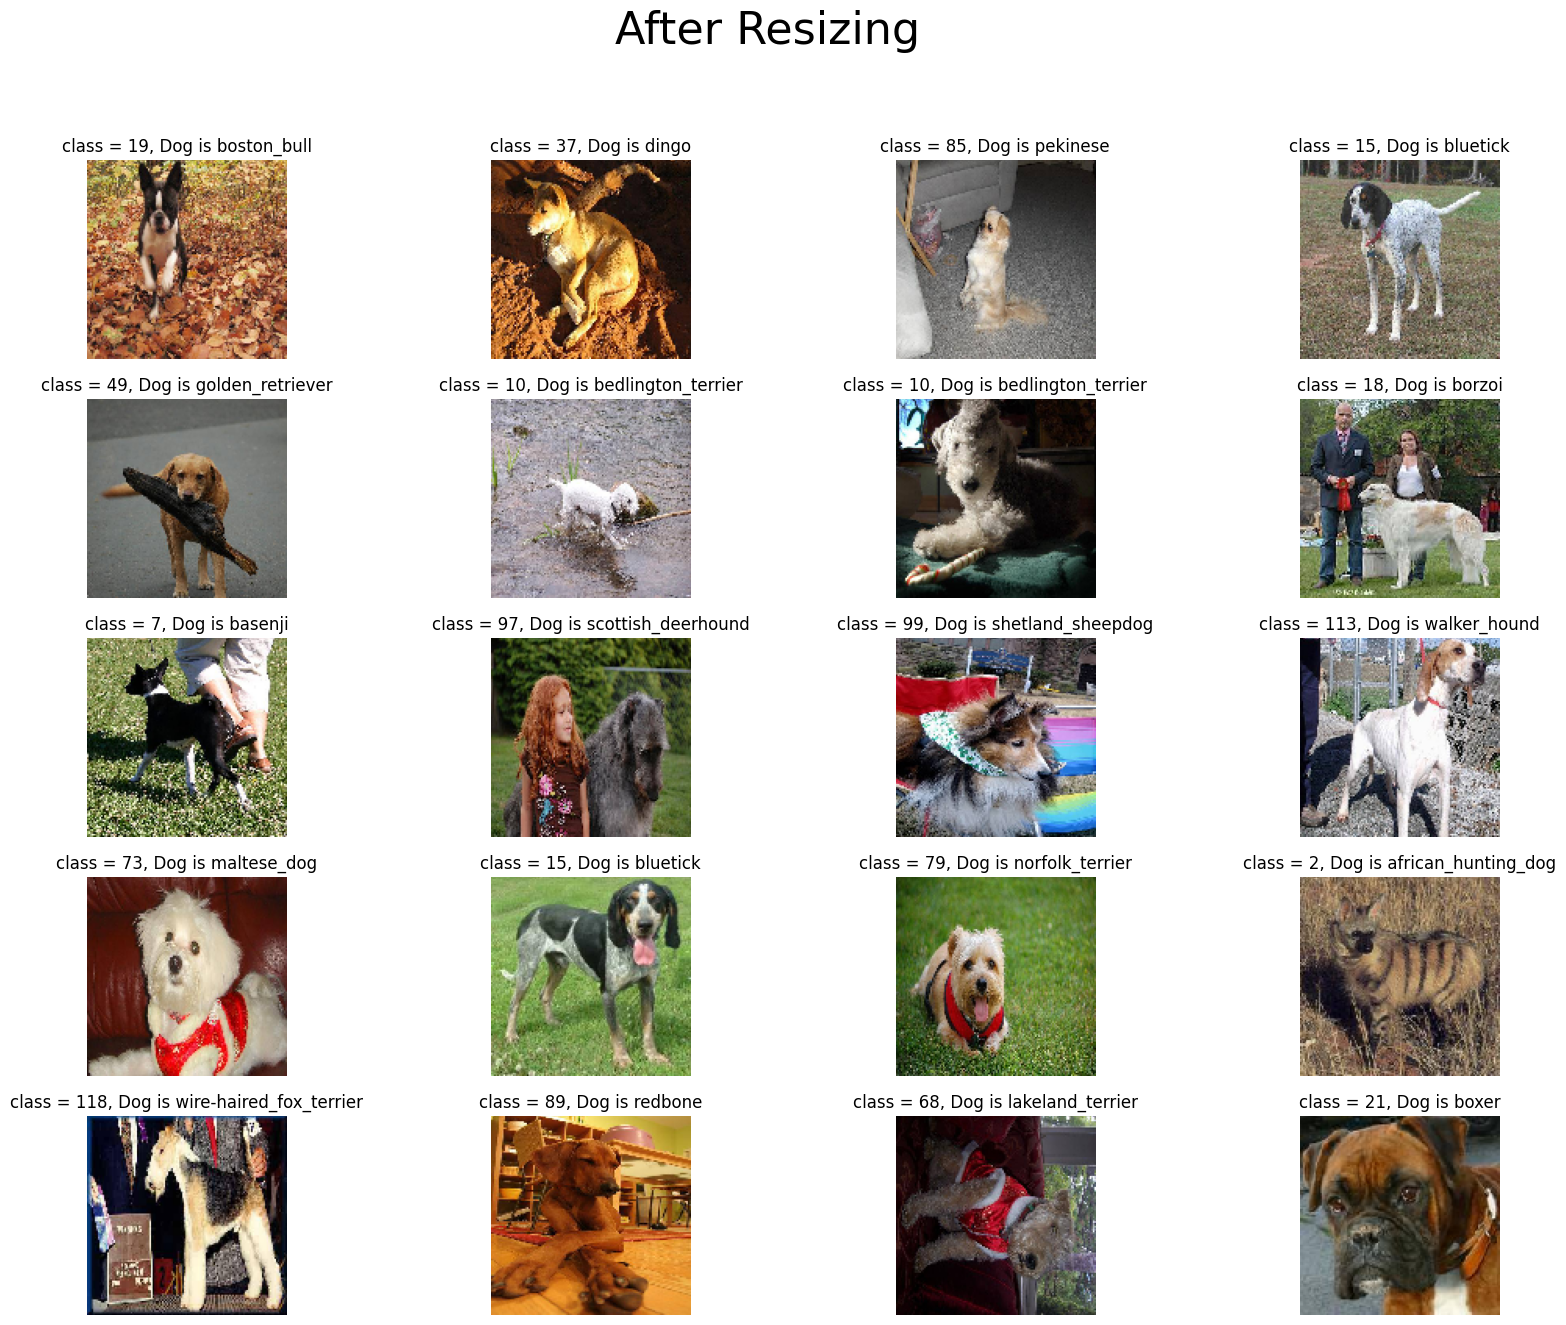

In [15]:
nrow = 5
ncol = 4  # 20 resim olduğu için sütun sayısını 4 yapabilirsiniz.
fig1 = plt.figure(figsize=(20, 15))
fig1.suptitle('After Resizing', size=32)

# İlk 20 resmi seç
for i in range(min(20, len(resized_image_list))):
    plt.subplot(nrow, ncol, i + 1)
    plt.imshow(resized_image_list[i])
    plt.title('class = {x}, Dog is {y}'.format(x=train_df["label"].iloc[i], y=labels[i]))
    plt.axis('Off')
    plt.grid(False)
plt.show()

In [16]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"), 
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.2)
], name='data_augmentation')

In [17]:
augmented_images = data_augmentation(resized_image_list)

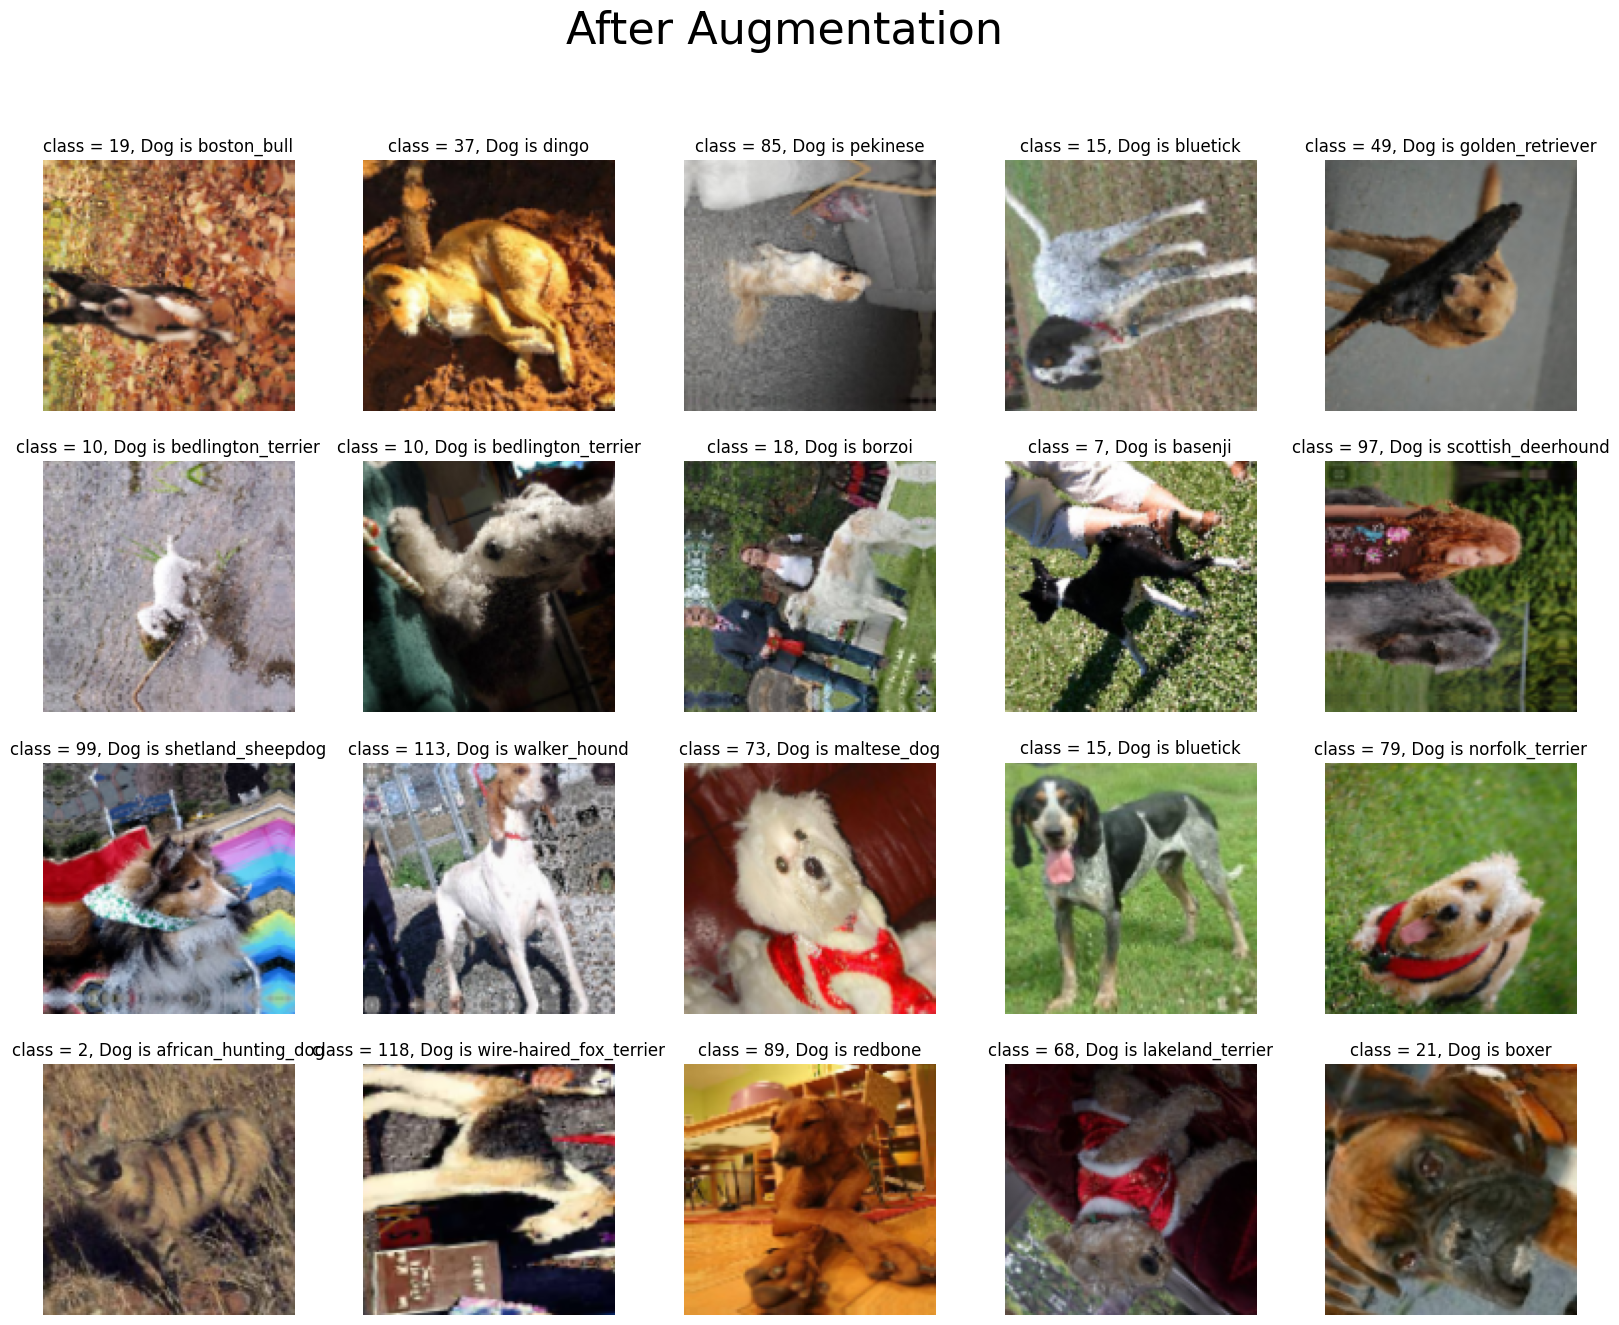

In [18]:
nrow = 4
ncol = 5

# İlk 20 augmentasyonlu resmi seç
augmented_indices = range(min(20, len(resized_image_list)))

fig2 = plt.figure(figsize=(20, 15))
fig2.suptitle('After Augmentation', size=32)

for i, idx in enumerate(augmented_indices):
    augmented_image = data_augmentation(tf.expand_dims(resized_image_list[idx], 0), training=True)
    plt.subplot(nrow, ncol, i + 1)
    plt.imshow(augmented_image[0].numpy())
    plt.title('class = {x}, Dog is {y}'.format(x=train_df["label"].iloc[idx], y=labels[idx]))
    plt.axis('Off')
    plt.grid(False)

plt.show()

In [19]:
class_values = train_df["label"]
filtered_values = class_values[class_values < 0]

if not filtered_values.empty:
    print("There are values in the series less than 0.")
else:
    print("There are no values in the series less than 0.")
class_values.value_counts()

There are no values in the series less than 0.


label
97    126
73    117
1     116
42    115
11    114
     ... 
49     67
22     67
65     67
43     66
23     66
Name: count, Length: 120, dtype: int64

In [20]:
# Assuming you have NumPy arrays for augmented_images and selected_labels
# Convert NumPy arrays to TensorFlow tensors
augmented_images_tf = tf.convert_to_tensor(augmented_images)
selected_labels_tf = tf.convert_to_tensor(train_df['label'])

# Convert TensorFlow tensors back to NumPy arrays
augmented_images_np = augmented_images_tf.numpy()
selected_labels_np = selected_labels_tf.numpy()

# Split them into training and validation using NUM_IMAGES 
X_train, X_test, y_train, y_test = train_test_split(
    augmented_images_np, 
    selected_labels_np,
    test_size=0.3,
    stratify = selected_labels_np,
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, 
    y_train,
    test_size=0.1,  # You can adjust the validation split as needed
    stratify = y_train,
    random_state=42
)

print("Training Set Length:", len(X_train))
print("Test Set Length:", len(X_test))                                  
print("Validation Set Length:", len(X_val))

Training Set Length: 6439
Test Set Length: 3067
Validation Set Length: 716


# Convolutional Neural Network

In [24]:
model = Sequential([
    Input(shape=(128, 128, 3)),
    Conv2D(8, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(120, activation='sigmoid'),
    Dropout(0.5),
    Dense(120, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])






In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 8)       224       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 64, 64, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 16)        1168      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 32, 32, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 16)        2320      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 16, 16, 16)       

In [28]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size = 32)

Epoch 1/10
202/202 [==============================] - 38s 186ms/step - loss: 4.7963 - accuracy: 0.0120 - val_loss: 4.7800 - val_accuracy: 0.0173
Epoch 2/10
202/202 [==============================] - 36s 179ms/step - loss: 4.7759 - accuracy: 0.0166 - val_loss: 4.7309 - val_accuracy: 0.0189
Epoch 3/10
202/202 [==============================] - 36s 179ms/step - loss: 4.7135 - accuracy: 0.0171 - val_loss: 4.6602 - val_accuracy: 0.0222
Epoch 4/10
202/202 [==============================] - 36s 178ms/step - loss: 4.6496 - accuracy: 0.0202 - val_loss: 4.6191 - val_accuracy: 0.0254
Epoch 5/10
202/202 [==============================] - 36s 180ms/step - loss: 4.5937 - accuracy: 0.0252 - val_loss: 4.5949 - val_accuracy: 0.0251
Epoch 6/10
202/202 [==============================] - 36s 179ms/step - loss: 4.5481 - accuracy: 0.0320 - val_loss: 4.5742 - val_accuracy: 0.0271
Epoch 7/10
202/202 [==============================] - 36s 180ms/step - loss: 4.4776 - accuracy: 0.0379 - val_loss: 4.5651 - val_ac

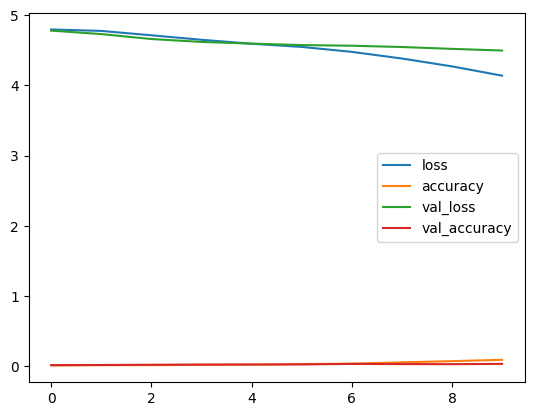

In [29]:
pd.DataFrame(model.history.history).plot()
plt.show()

In [30]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print("loss: ", loss)
print("accuracy: ", accuracy)

loss:  4.496573448181152
accuracy:  0.034887511283159256


96/96 [==============================] - 5s 52ms/step
[[3 1 0 ... 0 0 0]
 [1 0 0 ... 1 0 0]
 [0 0 1 ... 1 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 1 0 ... 1 0 0]
 [2 0 0 ... 2 0 0]]
              precision    recall  f1-score   support

           0       0.04      0.12      0.06        24
           1       0.00      0.00      0.00        35
           2       0.07      0.04      0.05        26
           3       0.00      0.00      0.00        32
           4       0.00      0.00      0.00        22
           5       0.00      0.00      0.00        23
           6       0.06      0.06      0.06        31
           7       0.00      0.00      0.00        33
           8       0.00      0.00      0.00        25
           9       0.00      0.00      0.00        31
          10       0.14      0.04      0.06        27
          11       0.05      0.12      0.07        34
          12       0.00      0.00      0.00        23
          13       0.04      0.06      0.05        31
          14   

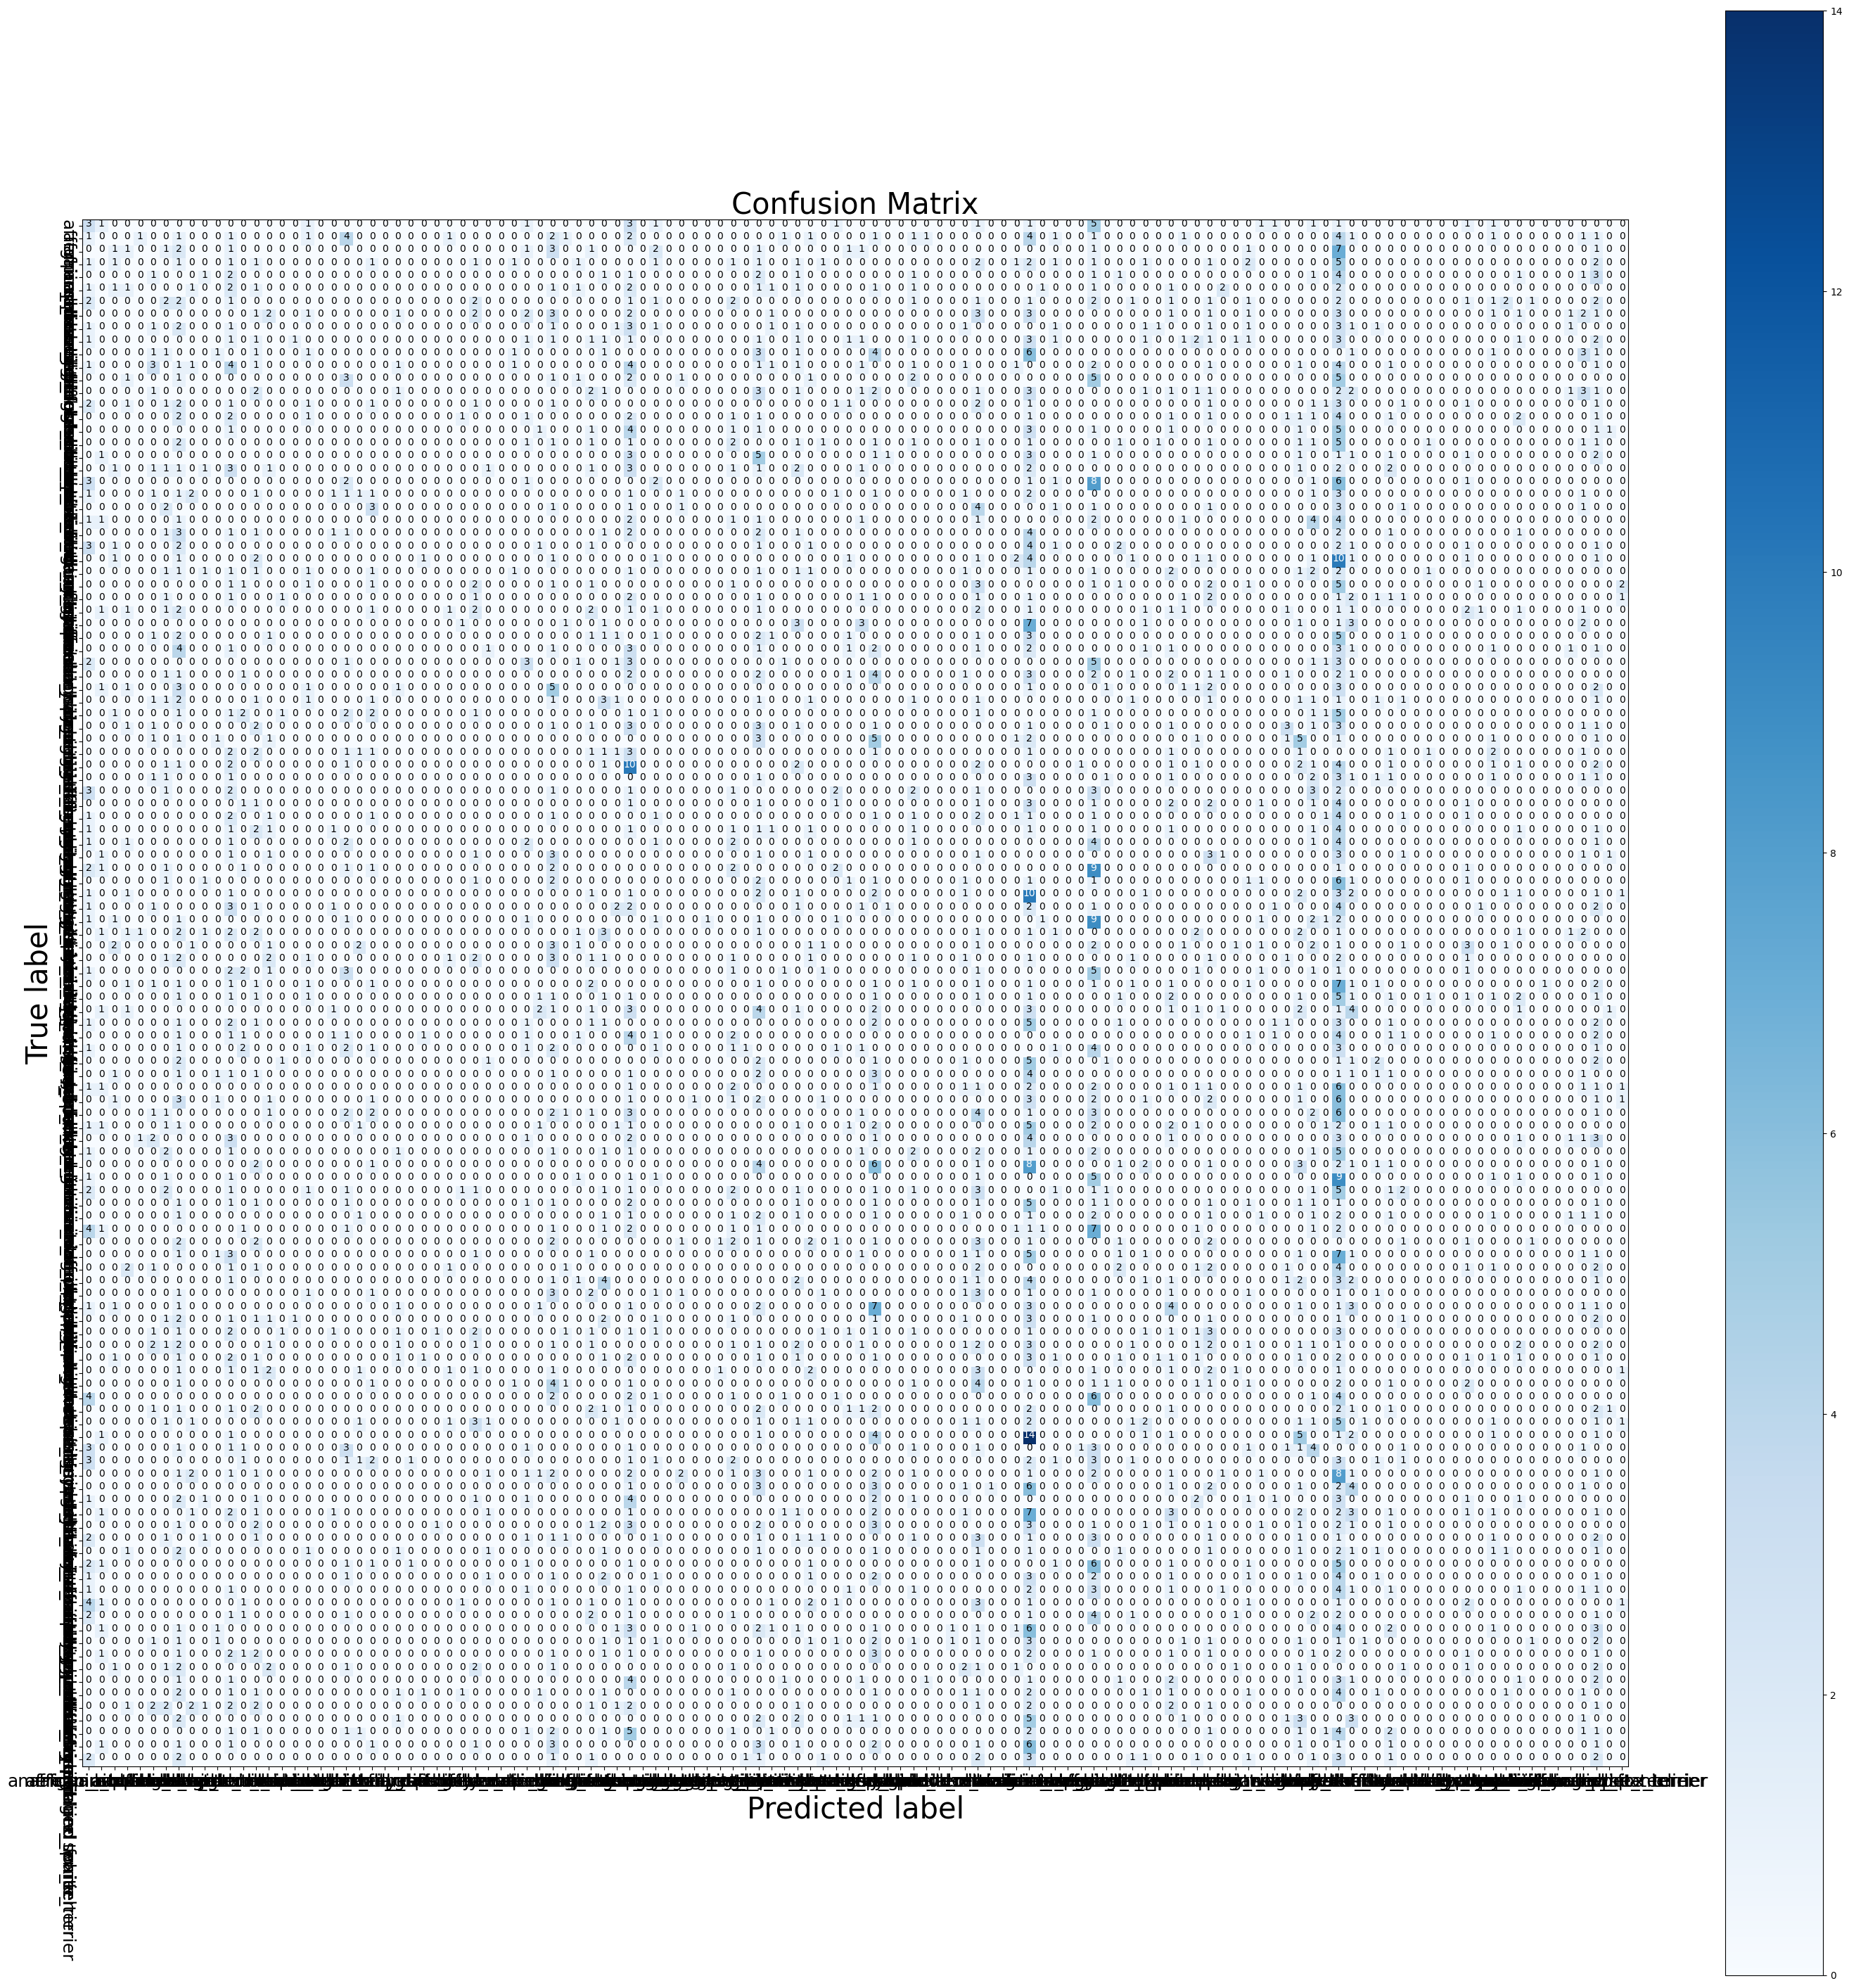

In [31]:
import itertools

pred_prob = model.predict(X_test)
y_pred = np.argmax(pred_prob, axis=1)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

predictions = np.array([])
labels = np.array([])



cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(29,29))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0,fontsize=18)
    plt.yticks(tick_marks, classes, rotation=270,fontsize=18)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=30)
    plt.xlabel('Predicted label',fontsize=30)
    
cm_plot_labels = dog_breeds[:]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [32]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score, recall_score

# Sınıf sayısını belirle
n_classes = len(set(y_test))

# Sınıfları ikili formata dönüştür
y_test_binary = label_binarize(y_test, classes=range(n_classes))
y_pred_binary = label_binarize(y_pred, classes=range(n_classes))

# Micro-averaging için average_precision_score kullanımı
model_AP_micro = average_precision_score(y_test_binary, y_pred_binary, average='weighted')

# Diğer performans metrikleri
model_precision = precision_score(y_test_binary, y_pred_binary, average='weighted')
model_recall = recall_score(y_test_binary, y_pred_binary, average='weighted')

print(f'Weighted-Averaged AP: {model_AP_micro:.2f}')
print(f'Weighted-Averaged Precision: {model_precision:.2f}')
print(f'Weighted-Averaged Recall: {model_recall:.2f}')

Weighted-Averaged AP: 0.01
Weighted-Averaged Precision: 0.02
Weighted-Averaged Recall: 0.03


In [33]:
n_classes

120